In [ ]:
import torch
print(torch.__version__)

1.8.1+cu101


In [ ]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd
from six.moves import urllib
import random
from skimage.util import random_noise
from math import log10
import torch.nn.functional as F
import math

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Mon Apr 19 13:31:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Read the train and test sets of CIFAR-10 data
default_transform = transforms.Compose([transforms.ToTensor()])
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=default_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=default_transform)
print("Training set size:", len(cifar_trainset))
print("Test set size:", len(cifar_testset))


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


In [ ]:
# Initialize data loader functions
BATCH_SIZE = 64
train_dataLoader = DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_dataLoader = DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Validate shape of the input images
dataiter = iter(train_dataLoader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


In [ ]:
def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [ ]:
def conv3x3(in_channels, out_channels, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, groups=groups, bias=False)

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4  # # output cahnnels / # input channels

    def __init__(self, inplanes, outplanes, stride=1):
        assert outplanes % self.expansion == 0
        super(Bottleneck, self).__init__()
        self.inplanes = inplanes
        self.outplanes = outplanes
        self.bottleneck_planes = int(outplanes / self.expansion)
        self.stride = stride

        self._make_layer()

    def _make_layer(self):
        # conv 1x1
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.conv1 = nn.Conv2d(self.inplanes, self.bottleneck_planes,
                               kernel_size=1, stride=self.stride, bias=False)
        # conv 3x3
        self.bn2 = nn.BatchNorm2d(self.bottleneck_planes)
        self.conv2 = nn.Conv2d(self.bottleneck_planes, self.bottleneck_planes,
                               kernel_size=3, stride=1, padding=1, bias=False)
        # conv 1x1
        self.bn3 = nn.BatchNorm2d(self.bottleneck_planes)
        self.conv3 = nn.Conv2d(self.bottleneck_planes, self.outplanes, kernel_size=1,
                               stride=1)
        if self.inplanes != self.outplanes:
            self.shortcut = nn.Conv2d(self.inplanes, self.outplanes, kernel_size=1,
                                      stride=self.stride, bias=False)
        else:
            self.shortcut = None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        # we do pre-activation
        out = self.relu(self.bn1(x))
        out = self.conv1(out)

        out = self.relu(self.bn2(out))
        out = self.conv2(out)

        out = self.relu(self.bn3(out))
        out = self.conv3(out)

        if self.shortcut is not None:
            residual = self.shortcut(residual)

        out += residual
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, depth, output_classes=10):
        assert (depth - 2) % 9 == 0  # 164 or 1001
        super(ResNet, self).__init__()
        n = int((depth - 2) / 9)
        nstages = [16, 64, 128, 256]
        # one conv at the beginning (spatial size: 32x32)
        self.conv1 = nn.Conv2d(3, nstages[0], kernel_size=3, stride=1,
                               padding=1, bias=False)

        # use `block` as unit to construct res-net
        # Stage 0 (spatial size: 32x32)
        self.layer1 = self._make_layer(block, nstages[0], nstages[1], n)
        # Stage 1 (spatial size: 32x32)
        self.layer2 = self._make_layer(block, nstages[1], nstages[2], n, stride=2)
        # Stage 2 (spatial size: 16x16)
        self.layer3 = self._make_layer(block, nstages[2], nstages[3], n, stride=2)
        # Stage 3 (spatial size: 8x8)
        self.bn = nn.BatchNorm2d(nstages[3])
        self.relu = nn.ReLU(inplace=True)
        # classifier
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(nstages[3], output_classes)

        # weight initialization
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, inplanes, outplanes, nstage, stride=1):
        layers = []
        layers.append(block(inplanes, outplanes, stride))
        for i in range(1, nstage):
            layers.append(block(outplanes, outplanes, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.relu(self.bn(x))

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
def get_accuracy(model, dataloader):
  """
    Function to compute accuracy given a model (of class nn) and a dataloader object
  """
  
  model.eval()
  correct_predictions = 0
  with torch.no_grad():
    for images, labels in dataloader:
      imgs = images.to(device)
      lbls = labels.to(device)
      # images = images.view(images.shape[0], -1)
      output = model(imgs)
      _, predicted = torch.max(output.data, 1)
      correct_predictions += (predicted == lbls).sum().item()
  accuracy = (correct_predictions / len(dataloader.dataset)) * 100
  return(accuracy)


In [ ]:
def train_network(model, num_epochs, learning_rate, train_dataLoader, test_dataLoader, lr_update_rule):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_accuracy_list, test_accuracy_list, train_loss_list = [], [], [] 
  for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_dataLoader:
      imgs = images.to(device)
      lbls = labels.to(device)
  
      # Training step
      optimizer.zero_grad()
      out = model(imgs)
      loss = criterion(out, lbls)
      
      # Backpropagate loss
      loss.backward()
      
      # Optimize weights
      optimizer.step()
      
      running_loss += loss.item()
    
    train_loss = running_loss/len(train_dataLoader)
    train_loss_list.append(train_loss)
    train_accuracy = get_accuracy(model, train_dataLoader)
    train_accuracy_list.append(train_accuracy)
    
    test_accuracy = get_accuracy(model, test_dataLoader)
    test_accuracy_list.append(test_accuracy)
    print("Epoch: {} \t Training loss: {} \t Training accuracy: {} \t Test accuracy: {}".format(epoch, train_loss, train_accuracy, test_accuracy))
    
  return model, train_accuracy_list, test_accuracy_list, train_loss_list

In [ ]:
# Hyper-parameters
EPOCHS = 100
lr = 0.001
lr_update = {80:0.0001, 120:0.00001, 160:0.000001}

In [ ]:
resnet164B = ResNet(Bottleneck, 164, 10).to(device)
resnet164B, train_acc_164B, test_acc_164B, train_loss_164B = train_network(model=resnet164B,
                                                                       num_epochs=EPOCHS,
                                                                       learning_rate=lr,
                                                                       train_dataLoader=train_dataLoader,
                                                                       test_dataLoader=test_dataLoader,
                                                                       lr_update_rule=lr_update)

Epoch: 0 	 Training loss: 1.447320126054232 	 Training accuracy: 56.596000000000004 	 Test accuracy: 55.08
Epoch: 1 	 Training loss: 1.2090078862503058 	 Training accuracy: 63.124 	 Test accuracy: 61.35
Epoch: 2 	 Training loss: 0.9538080847781637 	 Training accuracy: 67.878 	 Test accuracy: 66.02
Epoch: 3 	 Training loss: 0.8438122456564623 	 Training accuracy: 70.082 	 Test accuracy: 67.47999999999999
Epoch: 4 	 Training loss: 0.7419529908605854 	 Training accuracy: 76.89 	 Test accuracy: 72.82
Epoch: 5 	 Training loss: 0.6518313613389154 	 Training accuracy: 81.91000000000001 	 Test accuracy: 76.55999999999999
Epoch: 6 	 Training loss: 0.5739468736264407 	 Training accuracy: 82.124 	 Test accuracy: 76.07000000000001
Epoch: 7 	 Training loss: 0.5006985516308824 	 Training accuracy: 83.87400000000001 	 Test accuracy: 76.61
Epoch: 8 	 Training loss: 0.43633769262019934 	 Training accuracy: 87.208 	 Test accuracy: 78.53999999999999
Epoch: 9 	 Training loss: 0.3819953023129717 	 Training

In [ ]:
import pandas as pd
metric_data = pd.DataFrame({'Epoch': range(1,EPOCHS+1), 'Train_Acc': train_acc_164B, 'Test_Acc': test_acc_164B, 'Train_Loss': train_loss_164B})
metric_data.to_csv('ResNet164_B.csv', index=False)

In [ ]:
torch.save(resnet164B, 'ResNet164_B.pt')

# PLOTS

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [8]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Deep Learning Project/All results/CSV Files'
os.chdir(root)
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Deep Learning Project/All results/CSV Files'

In [9]:
!ls

ResNet110_B.csv      ResNet110.csv	ResNet164_B.csv      ResNet164.csv
ResNet110_B_ic1.csv  ResNet110_ic1.csv	ResNet164_B_ic1.csv  ResNet164_ic1.csv
ResNet110_B_ic2.csv  ResNet110_ic2.csv	ResNet164_B_ic2.csv  ResNet164_ic2.csv
ResNet110_B_ic3.csv  ResNet110_ic3.csv	ResNet164_B_ic3.csv  ResNet164_ic3.csv


In [10]:
metrics_110 = pd.read_csv("ResNet110.csv")
metrics_110_ic1 = pd.read_csv("ResNet110_ic1.csv")
metrics_110_ic2 = pd.read_csv("ResNet110_ic2.csv")
metrics_110_ic3 = pd.read_csv("ResNet110_ic3.csv")


In [11]:
metrics_110.columns

Index(['Epoch', 'Train_Acc', 'Test_Acc', 'Train_Loss'], dtype='object')

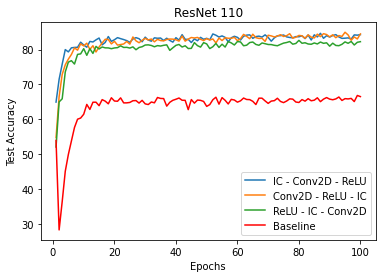

In [27]:
filename = 'resnet110.png'
plt.plot(range(1, 101),metrics_110_ic1['Test_Acc'], label="IC - Conv2D - ReLU")
plt.plot(range(1, 101),metrics_110_ic2['Test_Acc'], label="Conv2D - ReLU - IC")
plt.plot(range(1, 101),metrics_110_ic3['Test_Acc'], label="ReLU - IC - Conv2D")
plt.plot(range(1, 101),metrics_110['Test_Acc'][:100], label="Baseline", color="red")
plt.legend()
plt.title('ResNet 110')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.savefig(filename, dpi=500)
plt.show()

In [17]:
metrics_110B = pd.read_csv("ResNet110_B.csv")
metrics_110B_ic1 = pd.read_csv("ResNet110_B_ic1.csv")
metrics_110B_ic2 = pd.read_csv("ResNet110_B_ic2.csv")
metrics_110B_ic3 = pd.read_csv("ResNet110_B_ic3.csv")

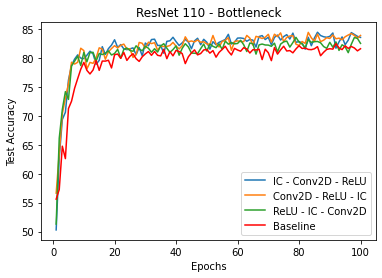

In [26]:
filename = 'resnet110_B.png'
plt.plot(range(1, 101),metrics_110B_ic1['Test_Acc'], label="IC - Conv2D - ReLU")
plt.plot(range(1, 101),metrics_110B_ic2['Test_Acc'], label="Conv2D - ReLU - IC")
plt.plot(range(1, 101),metrics_110B_ic3['Test_Acc'], label="ReLU - IC - Conv2D")
plt.plot(range(1, 101),metrics_110B['Test_Acc'][:100], label="Baseline", color="red")
plt.legend()
plt.title('ResNet 110 - Bottleneck')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.savefig(filename, dpi=500)
plt.show()

In [19]:
metrics_164 = pd.read_csv("ResNet164.csv")
metrics_164_ic1 = pd.read_csv("ResNet164_ic1.csv")
metrics_164_ic2 = pd.read_csv("ResNet164_ic2.csv")
metrics_164_ic3 = pd.read_csv("ResNet164_ic3.csv")

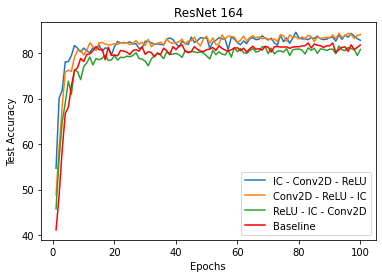

In [28]:
filename = 'resnet164.png'
plt.plot(range(1, 101),metrics_164_ic1['Test_Acc'], label="IC - Conv2D - ReLU")
plt.plot(range(1, 101),metrics_164_ic2['Test_Acc'], label="Conv2D - ReLU - IC")
plt.plot(range(1, 101),metrics_164_ic3['Test_Acc'], label="ReLU - IC - Conv2D")
plt.plot(range(1, 101),metrics_164['Test_Acc'][:100], label="Baseline", color="red")
plt.legend()
plt.title('ResNet 164')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.savefig(filename, dpi=500)
plt.show()

In [21]:
metrics_164B = pd.read_csv("ResNet164_B.csv")
metrics_164B_ic1 = pd.read_csv("ResNet164_B_ic1.csv")
metrics_164B_ic2 = pd.read_csv("ResNet164_B_ic2.csv")
metrics_164B_ic3 = pd.read_csv("ResNet164_B_ic3.csv")

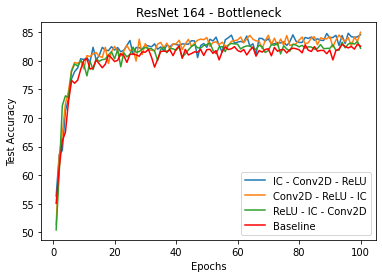

In [29]:
filename = 'resnet164_B.png'
plt.plot(range(1, 101),metrics_164B_ic1['Test_Acc'], label="IC - Conv2D - ReLU")
plt.plot(range(1, 101),metrics_164B_ic2['Test_Acc'], label="Conv2D - ReLU - IC")
plt.plot(range(1, 101),metrics_164B_ic3['Test_Acc'], label="ReLU - IC - Conv2D")
plt.plot(range(1, 101),metrics_164B['Test_Acc'][:100], label="Baseline", color="red")
plt.legend()
plt.title('ResNet 164 - Bottleneck')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.savefig(filename, dpi=500)
plt.show()